# Purpose

This notebook is to test whether the `neuro_op` module's agents can successfully infer `world_dist` if only that distribution's information pieces are absorbed (i.e., with rates h>0, r=0).

For this, the model is run and agents informed with different numbers of information exchanged (i.e., different `t_max`, `h`). Then, each agent will produce its posterior predictive distribution by sampling

In [1]:
import neuro_op as nop
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

In [14]:
N_beliefs = 500

agents, G, beliefs, world, N_events, t_end = nop.run_model(
    N_agents=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(N_beliefs),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=0,
    t_max=10000,
)

print(f"Number of events: {N_events}")

Number of events: 10124


In [15]:
plt.rcParams.update({"font.size": 25})

Text(0, 0.5, '$p(\\mu|x_i)$')

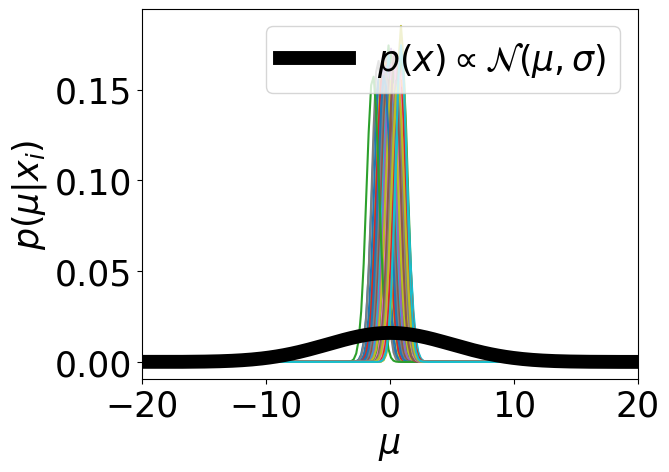

In [16]:
for i in range(len(agents)):
    plt.plot(agents[0].beliefs, nop.logpdf_to_pdf(agents[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

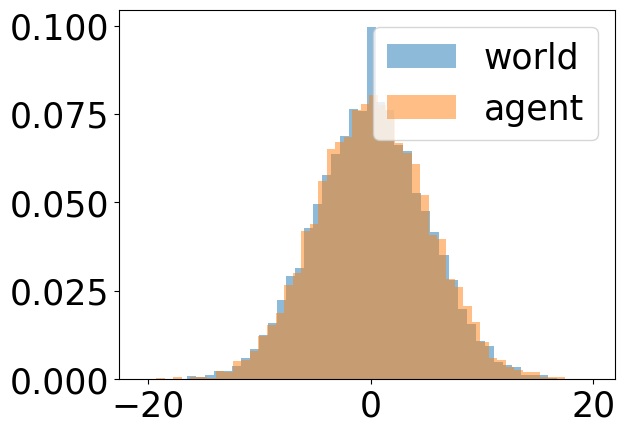

In [17]:
ppd = nop.ppd_Gaussian_mu(agents[0].beliefs, agents[0].log_probs, 10000)

plt.hist(world.diary_out, bins=50, density=True, alpha=0.5, label="world")
plt.hist(ppd, bins=50, density=True, alpha=0.5, label="agent")
plt.legend()

In [18]:
Q_binned = nop.dist_binning(world.likelihood, range=(-20,20), N_bins=50)

P_sampled,_ = np.histogram(ppd, bins=50, range=[-20,20])
P_sampled = P_sampled / np.sum(P_sampled)

nop.kl_divergence(P_sampled, Q_binned)

0.0030199260727803417